In [112]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import torch 
import torch.nn.functional as F
from torch.autograd.functional import hessian
from torch.distributions.multivariate_normal import MultivariateNormal
import seaborn as sns

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Favor <u>não</u> enviar um .zip dos arquivos.
Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um **<u>*único pdf*</u>**.

# Trabalho de casa 03: Regressão logística e inferência Bayesiana aproximada

O pedaço de código abaixo carrega o banco de dados 'breast cancer' e adiciona uma coluna de bias. Além disse, ele o particiona em treino e teste.

1. Implemente a estimativa de máximo a posteriori para um modelo de regressão logística com priori $\mathcal{N}(0, c I)$ com $c=100$ usando esse banco de dados;
2. Implemente a aproximação de Laplace para o mesmo modelo;
3. Implemente uma aproximação variacional usando uma Gaussiana diagonal e o truque da reparametrização;
4. Calcule a accuracy no teste para todas as opções acima --- no caso das 2 últimas, a prob predita é $\int_\theta p(y|x, \theta) q(\theta)$;
5. Para cada uma das 3 técnicas, plote um gráfico com a distribuição das entropias para as predições corretas e erradas (separadamente), use a função kdeplot da biblioteca seaborn.
6. Comente os resultados, incluindo uma comparação dos gráficos das entropias.

Explique sua implementação também! 

Para facilitar sua vida: use PyTorch, Adam para otimizar (é uma variação SGD) com lr=0.001, use o banco de treino inteiro ao invés de minibatchces, use `binary_cross_entropy_with_logits` para implementar a -log verossimilhança, use `torch.autograd.functional` para calcular a Hessiana. Você pode usar as bibliotecas importadas na primeira célula à vontade. Verifique a documentação de `binary_cross_entropy_with_logits` para garantir que a sua priori está implementada corretamente, preservando as proporções devidas. Use 10000 amostras das aproximações para calcular suas predições.

In [113]:
data =  load_breast_cancer()
N = len(data.data)
Ntrain = int(np.ceil(N*0.6))
perm = np.random.permutation(len(data.data))
X = torch.tensor(data.data).float()
X = torch.cat((X, torch.ones((X.shape[0], 1))), axis=1) 
y = torch.tensor(data.target).float()

Xtrain, ytrain = X[perm[:Ntrain]], y[perm[:Ntrain]]
Xtest, ytest = X[perm[Ntrain:]], y[perm[Ntrain:]]

# Entropia

Antes de começar a implementar as técnicas, vamos implementar uma função que gere o plot das entropias, afim de facilitar a visualização dos dados pra cada método. 

A função abaixo *entropia(y_prob, y_pred)* recebe como parâmetros o vetor de rótulos e o vetor de predições. Ela calcula a entropia de cada predição e separa as entropias das predições corretas e erradas. Por fim, ela plota um gráfico com a distribuição das entropias para as predições corretas e erradas.

In [114]:
def entropia(y_prob, y_pred):

    #definindo as listas que vão armazenar as entropias
    entropiacorreta = []
    entropiaerrada = []

    #loop para calcular a entropia de cada elemento
    for i in range(y_prob.shape[0]):
        #se o y_pred for igual ao y_test, a entropia é calculada com base no y_prob
        if y_pred[i] == ytest[i]:
            entropy = -y_prob[i] * torch.log(y_prob[i]) - (1-y_prob[i]) * torch.log(1-y_prob[i]) 
            entropy = entropy.detach().numpy() # makes it an array
            entropy = np.nan_to_num(entropy)
            entropiacorreta.append(entropy)
            #se o y_pred for diferente do y_test, a entropia é calculada com base no y_prob
        else:
            entropy = -y_prob[i] * torch.log(y_prob[i]) - (1-y_prob[i]) * torch.log(1-y_prob[i])
            entropy = entropy.detach().numpy() # makes it an array
            entropy = np.nan_to_num(entropy)
            entropiaerrada.append(entropy) 
    

    #transformando as listas em arrays
    entropiacorreta = np.array(entropiacorreta)
    entropiaerrada = np.array(entropiaerrada)

    return entropiacorreta, entropiaerrada

# Estimativa de Máxima a Posteriori

Seguindo as notas de aula, a maximização à posteriori é dada por:




$$\hat{\theta}_{MAP} = \arg\max_{\theta} \log p(\theta) +  \log p( \theta)$$

No nosso caso, vamos considerar o argumento que minimiza a o negativo da mesma função, ou seja, 
$$\hat{\theta}_{MAP} = arg_{\theta} min - \log p(D|\theta) - \log p(\theta)$$

A função *maximum_a_posteriori()* abaixo implementa o cálculo do MAP para o modelo de regressão logística. Ela retorna o vetor de pesos $\theta$ que minimiza a função.

In [115]:

def maximum_a_posteriori(X: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    priori_var = 100
    learning_rate = 0.001

    # Inicialização
    d = X.shape[1]

    #definindo theta que é a variável que será otimizada e optimizer que é o otimizador
    # theta = torch.empty(d).normal_(std=priori_var ** 0.5).requires_grad_(True)
    theta = torch.empty(d).normal_(std=1).requires_grad_(True)
    optimizer = torch.optim.Adam([theta], lr=learning_rate)

    #definindo quantidade de iterações 
    epochs = 10000
   

    for i in range(epochs):
        #zerando o gradiente
        optimizer.zero_grad()
        
        #log verossimilhança negativa
        #negativeloglikelihood = F.binary_cross_entropy_with_logits(torch.matmul(X,theta))
        negativeloglikelihood = F.binary_cross_entropy_with_logits(torch.matmul(X, theta), y)

        #priori
        priori = MultivariateNormal(torch.zeros(d), priori_var * torch.eye(d)).log_prob(theta)  

        #log posteriori
        logposteriori = negativeloglikelihood - priori

        #atualizando theta
        logposteriori.backward()
        optimizer.step()
        
    return theta

In [116]:

theta = maximum_a_posteriori(Xtrain, ytrain)

In [117]:
y_pred = (torch.sigmoid(Xtrain @ theta)) >= 0.5
print("Accuracy on train set: ", (y_pred == ytrain).sum().item()/len(ytrain))

Accuracy on train set:  0.9473684210526315


In [118]:
y_prob = torch.sigmoid(Xtest @ theta)
y_pred = (y_prob >= 0.5)
print("Accuracy on test set: ", (y_pred == ytest).sum().item()/len(ytest))

Accuracy on test set:  0.9383259911894273


C:\Users\Daniel\AppData\Local\Temp\ipykernel_15968\2384651437.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(entropiacerta, label='Corretas', shade=True)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_15968\2384651437.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(entropiaerrada, label='Incorretas', shade=True)


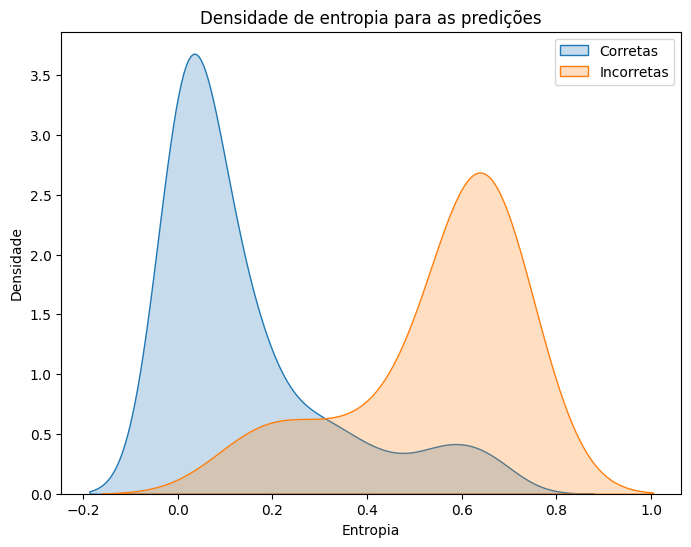

In [119]:
entropiacerta, entropiaerrada = entropia(y_prob, y_pred)

plt.figure(figsize=(8, 6))
sns.kdeplot(entropiacerta, label='Corretas', shade=True)
sns.kdeplot(entropiaerrada, label='Incorretas', shade=True)
plt.legend()
plt.title('Densidade de entropia para as predições')
plt.xlabel('Entropia')
plt.ylabel('Densidade')
plt.show()

# Aproximação de Laplace
Seguindo as notas de aula, a aproximação de Laplace segue a equação abaixo


$$q(\theta) = \mathcal{N}(\theta|\mu = m, \Sigma = H^{-1})$$
onde 
$$m = arg_{\theta} max p(\theta| \mathcal{D})$$
$$H = - \nabla^2_{\theta}(-\log p(\theta| \mathcal{D}))|_{\theta = m}$$

---

In [120]:
d = X.shape[1]

def posteriori(theta):
    logits = Xtrain @ theta
    negativeloglikelihood = F.binary_cross_entropy_with_logits(logits, ytrain)
    logpriori = MultivariateNormal(torch.zeros(d), 100*torch.eye(d)).log_prob(theta)
    return negativeloglikelihood - logpriori

hessiana = hessian(posteriori, theta)

media = theta.detach().numpy().copy()
covariancia = torch.inverse(hessiana).detach().numpy().copy()

T = 10000

samples = np.random.multivariate_normal(media, covariancia, size=T)
Xtheta = Xtrain @ torch.tensor(samples).float().t()

C:\Users\Daniel\AppData\Local\Temp\ipykernel_15968\3220586577.py:16: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(media, covariancia, size=T)


In [121]:
y_prob = torch.sigmoid(Xtheta).mean(axis=1)
y_pred = torch.tensor(y_prob) >= 0.5
print("Accuracy on train set: ", (y_pred==ytrain).sum().item()/len(ytrain))

Accuracy on train set:  0.9473684210526315


C:\Users\Daniel\AppData\Local\Temp\ipykernel_15968\4043667898.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = torch.tensor(y_prob) >= 0.5


In [122]:
Xtheta = Xtest @ torch.tensor(samples).float().t()

#get the probability of the samples
y_prob = torch.sigmoid(Xtheta).mean(axis=1)
y_pred = torch.tensor(y_prob) >= 0.5
print("Accuracy on test set: ", (y_pred==ytest).sum().item()/len(ytest))

Accuracy on test set:  0.9383259911894273


C:\Users\Daniel\AppData\Local\Temp\ipykernel_15968\1411344942.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = torch.tensor(y_prob) >= 0.5


C:\Users\Daniel\AppData\Local\Temp\ipykernel_15968\2384651437.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(entropiacerta, label='Corretas', shade=True)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_15968\2384651437.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(entropiaerrada, label='Incorretas', shade=True)


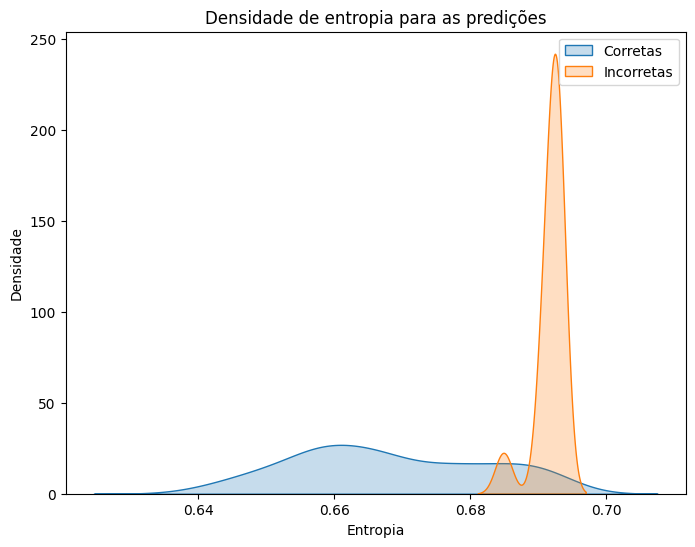

In [123]:
entropiacerta, entropiaerrada = entropia(y_prob, y_pred)

plt.figure(figsize=(8, 6))
sns.kdeplot(entropiacerta, label='Corretas', shade=True)
sns.kdeplot(entropiaerrada, label='Incorretas', shade=True)
plt.legend()
plt.title('Densidade de entropia para as predições')
plt.xlabel('Entropia')
plt.ylabel('Densidade')
plt.show()

# Aproximação variacional

In [124]:
# variational inference for logistic regression

mu = torch.randn(d, requires_grad=True)
c = torch.randn(d, requires_grad=True)

optimizer = torch.optim.Adam([mu, c], lr=0.01)

T = 100

for i in range(1000):
    optimizer.zero_grad()

    ss = F.softplus(c)
    thetas = torch.randn(T, d) @ torch.diag(ss) + mu
    loss = 0

    for t in range(T):
        theta = thetas[t, :]
        logits = Xtrain @ theta
        
        negativeloglikelihood = F.binary_cross_entropy_with_logits(logits, ytrain) 
        logpriori = MultivariateNormal(torch.zeros(d), 100*torch.eye(d)).log_prob(theta) 
        log_q = MultivariateNormal(mu, ss*torch.eye(d)).log_prob(theta)
        
        loss += (negativeloglikelihood + log_q - logpriori)/T 
    
    loss.backward()
    optimizer.step()

ss_cov = ss*torch.eye(d)
ss_cov = ss_cov.detach().numpy().copy()
mu_np = mu.detach().numpy().copy()

samples = np.random.multivariate_normal(mu_np, ss_cov, size=10000)
Xtheta = Xtest @ torch.tensor(samples).float().t()

y_prob = torch.sigmoid(Xtheta).mean(axis=1)
y_pred = torch.tensor(y_prob) >= 0.5
print("Accuracy on test set: ", (y_pred==ytest).sum().item()/len(ytest))

Accuracy on test set:  0.9074889867841409


C:\Users\Daniel\AppData\Local\Temp\ipykernel_15968\408173879.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = torch.tensor(y_prob) >= 0.5


C:\Users\Daniel\AppData\Local\Temp\ipykernel_15968\2384651437.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(entropiacerta, label='Corretas', shade=True)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_15968\2384651437.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(entropiaerrada, label='Incorretas', shade=True)


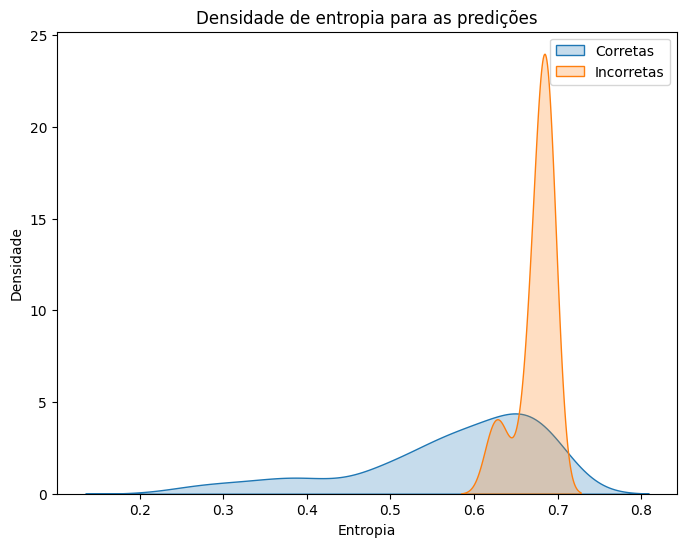

In [125]:
entropiacerta, entropiaerrada = entropia(y_prob, y_pred)

plt.figure(figsize=(8, 6))
sns.kdeplot(entropiacerta, label='Corretas', shade=True)
sns.kdeplot(entropiaerrada, label='Incorretas', shade=True)
plt.legend()
plt.title('Densidade de entropia para as predições')
plt.xlabel('Entropia')
plt.ylabel('Densidade')
plt.show()

# Acurácias
A exibição das acurácias está logo abaixo da implementação de cada função executada anteriormente. Calculou-se tanto a acurácia para o treino quanto para o teste.

# Entropias
A exibição das entropias foi feita logo após a exibição das acurácias em cada método.

Finalmente, faremos uma análise dos gráficos plotados para cada método. Quanto mais à esquerda as curvas de predição corretas - em azul -  estiverem posicionadas, menor é a entropia, o que sugere uma maior confiança nas previsões. Portanto, é desejável que a curva representando as previsões corretas - em azul - esteja localizada mais à esquerda (ou pelo menos minimamente abaixo da curva de erros - em laranja - no canto direito dos gráficos), indicando uma alta precisão - ou seja, maior confiança ao prever corretamente.

No primeiro gráfico, do MAP, observamos uma frequência considerável de entropia zero para as previsões corretas. Isso é justificado pelo fato de estarmos realizando uma predição pontual e obtendo nosso vetor de pesos final por meio de iterações com o otimizador. Como resultado, não estamos quantificando a incerteza tão bem quanto nas outras abordagens.

No gráfico da aproximação de Laplace, observamos uma melhor quantificação da incerteza, com a aproximação da posteriori por uma distribuição normal com média no MAP e a matriz de covariância. Como resultado, ambas as curvas se deslocam para maior entropia, mas ainda observamos uma concentração de erros em valores maiores de entropia, indicando que o modelo de fato apresenta mais incerteza nos casos em que faz previsões incorretas.

Por fim, para a inferência variacional, observamos um resultado semelhante, com valores de entropia maiores do que no caso do MAP, mas ainda concentrados em erros em valores altos de entropia. Isso é positivo, pois indica que o modelo detecta maior confusão nos casos em que erra. Essa informação é valiosa, uma vez que não seria desejável errarmos sem termos consciência da maior incerteza associada a esse ponto.

# Exercícios de "papel e caneta"

1. Derive a fórmula para a divergência KL entre duas distribuições Gaussianas univariadas, i.e., $D_\text{KL}\left(\mathcal{N}(\mu_1, \sigma_1^2) \| \mathcal{N}(\mu_2, \sigma_2^2)\right)$;

2. Suponha que $P$ é a família das distribuições categóricas com suporte em $\{1,\ldots, L\}$. Qual $p \in P$ possui maior entropia? 

3. Use a [desigualdade de Jensen](https://en.wikipedia.org/wiki/Jensen%27s_inequality) para mostrar que a divergência KL é não-negativa.

> **Dica:** A desigualdade de Jensen afirma que, se $\varphi$ é uma função convexa, então $\varphi(\mathbb{E}[X]) \leq \mathbb{E}[\varphi(X)]$.

4. Derive a aproximação de Laplace para a distribuição [Beta](https://en.wikipedia.org/wiki/Beta_distribution)($\alpha, \beta$). Mostre uma fórmula para valores genéricos $\alpha,\beta>1$ e a instancie para $\alpha=\beta=2$.

5. Derive a posteriori para o modelo Bayesiano com verossimilhança [Categórica](https://en.wikipedia.org/wiki/Categorical_distribution) e priori [Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution), i.e.:
\begin{alignat}{2}
y_1,\ldots, y_N &\sim Cat(\mathbf{\theta})\\
\mathbf{\theta} &\sim Dirichlet(\mathbf{\alpha})
\end{alignat}
onde $\mathbf{\theta}$ e $\mathbf{\alpha}$ são vetores $L$-dimensionais.


# Respostas 
# Questão 1
COnforme colinha fornecida pela monitora, a equação descrita no enunciado é
$$D_\text{KL}\left(\mathcal{N}(\mu_1, \sigma_1^2) \| \mathcal{N}(\mu_2, \sigma_2^2)\right) = \mathbb{E}_{\theta \sim q}\left[\log\left(\frac{p(\theta)}{q(\theta)}\right)\right]$$
Se ambas $p$ e $q$ são gaussianas, podemos rrescrevê-las como 
$$D_\text{KL}\left(\mathcal{N}(\mu_1, \sigma_1^2) \| \mathcal{N}(\mu_2, \sigma_2^2)\right) = \mathbb{E}_{\theta \sim q}\left[\log\left(\frac{\mathcal{N}(\mu_1, \sigma_1^2)}{\mathcal{N}(\mu_2, \sigma_2^2)}\right)\right]$$
$$D_\text{KL}\left(\mathcal{N}(\mu_1, \sigma_1^2) \| \mathcal{N}(\mu_2, \sigma_2^2)\right) = \mathbb{E}_{\theta \sim q}\left[\log\left(\frac{\frac{1}{\sqrt{2\pi\sigma_1^2}}\exp\left(-\frac{(\theta-\mu_1)^2}{2\sigma_1^2}\right)}{\frac{1}{\sqrt{2\pi\sigma_2^2}}\exp\left(-\frac{(\theta-\mu_2)^2}{2\sigma_2^2}\right)}\right)\right]$$
Simplificando a extressão ao aplicar log temos

$$D_\text{KL}\left(\mathcal{N}(\mu_1, \sigma_1^2) \| \mathcal{N}(\mu_2, \sigma_2^2)\right) = \mathbb{E}_{\theta \sim q}\left[\log\left(\frac{\sigma_2}{\sigma_1}\right)-\frac{\theta^2}{2\sigma_1^2}+\frac{2\theta\mu_1}{2\sigma_1^2}-\frac{\mu_1^2}{2\sigma_1^2}+\frac{\theta^2}{2\sigma_2^2}-\frac{2\theta\mu_2}{2\sigma_2^2}+\frac{\mu_2^2}{2\sigma_2^2}\right]$$
Separando os termos entre $\mu_1$ e $\mu_2$ temos
$$D_\text{KL}\left(\mathcal{N}(\mu_1, \sigma_1^2) \| \mathcal{N}(\mu_2, \sigma_2^2)\right) = \mathbb{E}_{\theta \sim q}\left[\log\left(\frac{\sigma_2}{\sigma_1}\right)\right]+\mathbb{E}_{\theta \sim q}\left[-\frac{\theta^2}{2\sigma_1^2}+\frac{2\theta\mu_1}{2\sigma_1^2}-\frac{\mu_1^2}{2\sigma_1^2}\right]+\mathbb{E}_{\theta \sim q}\left[\frac{\theta^2}{2\sigma_2^2}-\frac{2\theta\mu_2}{2\sigma_2^2}+\frac{\mu_2^2}{2\sigma_2^2}\right]$$ 
Removendo as contantes de dentro do valor esperado
$$D_\text{KL}\left(\mathcal{N}(\mu_1, \sigma_1^2) \| \mathcal{N}(\mu_2, \sigma_2^2)\right) = \mathbb{E}_{\theta \sim q}\left[\log\left(\frac{\sigma_2}{\sigma_1}\right)\right] + 
\frac{1}{2\sigma_1^2}\mathbb{E}_{\theta \sim q}\left[-\theta^2+2\theta\mu_1-\mu_1^2\right] + 
\frac{1}{2\sigma_2^2}\mathbb{E}_{\theta \sim q}\left[-\theta^2+2\theta\mu_2-\mu_2^2\right]
$$
Sabendo que $\theta \sim q$ podemos usar as propriedades de valor esperado para simplificar a expressão
$$\mathbb{E}_{\theta \sim q}(\theta) = \mu_1$$
$$\mathbb{E}_{\theta \sim q}(\theta^2) = \mathbb{E}_{\theta \sim q}(\theta)^2 + Var_{\theta \sim q}(\theta)$$
$$\mathbb{E}_{\theta \sim q}(\theta^2) = \mu_1^2 + \sigma_1^2$$
Aplicando sobre nossa derivação
$$D_\text{KL}\left(\mathcal{N}(\mu_1, \sigma_1^2) \| \mathcal{N}(\mu_2, \sigma_2^2)\right) = \log\left(\frac{\sigma_2}{\sigma_1}\right) +
\frac{1}{2\sigma_1^2}\left[-\mu_1^2 - \sigma_1^2 + 2\mu_1\mu_1 - \mu_1^2\right] +
\frac{1}{2\sigma_2^2}\left[-\mu_1^2 - \sigma_1^2 + 2\mu_1\mu_2 - \mu_2^2\right]
$$
Simplificando a expressão
$$D_\text{KL}\left(\mathcal{N}(\mu_1, \sigma_1^2) \| \mathcal{N}(\mu_2, \sigma_2^2)\right) = \log\left(\frac{\sigma_2}{\sigma_1}\right) -
\frac{1}{2} +
\frac{1}{2\sigma_2^2}\left[-\sigma_1^2 -(\mu_1 - \mu_2)^2\right]
$$


# Questão 2)
Tomando a equação de entropia da dada por $\sum_{i=1}^L p_i \log(p_i)$, vamos utilizar o método de multiplicadores e Lagrange pra aplicar a restrição de que a soma das probabilidades deve ser 1. Assim, temos a função a ser maximizada
$$\mathbb{L(\mathbf{p}, \lambda)} = -\sum_{i=1}^L p_i \log(p_i) + \lambda\left(\sum_{i=1}^L p_i - 1\right)$$
Tomando as derivadas parciais em $p_i$ e igualando a zero, temos
$$\frac{\partial \mathbb{L}}{\partial p_i} = -\log(p_i) + 1 + \lambda = 0$$
$$\log(p_i)= 1- \lambda$$
$$p_i = e^{1-\lambda}$$
Tomando então a restrição de que a soma das probabilidades deve ser 1, temos
$$\sum_{i=1}^L e^{1-\lambda} = \sum_{i=1}^L p_i = 1$$
$$L e^{1-\lambda} = 1$$
$$e^{1-\lambda} = \frac{1}{L}$$
Substituindo esse valor na derivada parcial de $p_i$ temos então
$$p_i = \frac{1}{L}$$
Concluímos então que a distribuição que maximiza a entropia é a distribuição uniforme, que é a que maximiza a incerteza sobre o resultado do evento.

# Questão 3)
A desigualdade de Jensen afirma que se $\varphi$ é uma função convexa, então $\varphi(\mathbb{E}[X]) \leq \mathbb{E}[\varphi(X)]$. Se tomarmos $\varphi(x) = -\log(x)$, temos que essa função é convexa, pois sua segunda derivada é positiva. Assim, temos que
$$-\log(\mathbb{E}[X]) \leq \mathbb{E}[-\log(X)]$$
Aplicando sobre o nosso problema, temos que
$$ - \log \mathbb{E}_{\theta \sim q}\left[\frac{p(\theta)}{q(\theta)}\right] \leq \mathbb{E}_{\theta \sim q}\left[\log\left(\frac{q(\theta)}{p(\theta)}\right)\right]$$
O primeiro termo pode ser reescrito como uma integral
$$ - \log \int q(\theta)\frac{p(\theta)}{q(\theta)}d\theta \leq \mathbb{E}_{\theta \sim q}\left[\log\left(\frac{q(\theta)}{p(\theta)}\right)\right]$$
Simplicando o primeiro termo 
$$ - \log \int p(\theta)d\theta \leq \mathbb{E}_{\theta \sim q}\left[\log\left(\frac{q(\theta)}{p(\theta)}\right)\right]$$
Como a integral de uma densidade de probabilidade em todo o espaço do parâmetro é $1$, temos que
$$ - \log 1 \leq \mathbb{E}_{\theta \sim q}\left[\log\left(\frac{q(\theta)}{p(\theta)}\right)\right]$$
$$ 0 \leq \mathbb{E}_{\theta \sim q}\left[\log\left(\frac{q(\theta)}{p(\theta)}\right)\right]$$
Concluímos aqui então que  desigualdade é sempre não negativa.

# Questão 4)
A aproximação de Laplace de $q(\theta)$ para a posterior $p(\theta|D)$ é dada por
$$q(\theta) = \mathcal{N}(\theta|\mu = m, \Sigma = \mathbb{H}^{-1})$$
onde 
$$\mathbb{H} = -\nabla^2( \log p(\theta|D))$$ 
$$m = \arg\max_\theta p(\theta|D)$$
Como estamos lidando com uma distribuição Beta, a moda é dada por
$$m = \frac{\alpha - 1}{\alpha + \beta - 2}$$
enquanto isso pra matriz Hessiana temos que a pdf da distribuição Beta é dada por
$$p(\theta) = \frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha, \beta)}$$
aplicando o logaritmo temos
$$\log(p(\theta)) = (\alpha-1)\log(\theta) + (\beta-1)\log(1-\theta) - \log(B(\alpha, \beta))$$
Derivando duas vezes em $\theta$ temos
$$\frac{\partial^2 \log(p(\theta))}{\partial \theta^2} = \frac{\alpha-1}{\theta^2} + \frac{\beta-1}{(1-\theta)^2}$$
Avaliando $\theta = m$ na função acima
$$\frac{\partial^2 \log(p(\theta))}{\partial \theta^2} = \frac{\alpha-1}{m^2} + \frac{\beta-1}{(1-m)^2}$$
Substituindo os valores de $\alpha$ e $\beta$ temos
$$\frac{\partial^2 \log(p(\theta))}{\partial \theta^2} = \frac{\alpha - 1}{\left(\frac{\alpha - 1}{\alpha + \beta - 2}\right)^2} + \frac{\beta -1}{\left(1-\left(\frac{\alpha - 1}{\alpha + \beta - 2}\right)\right)^2}$$
Agora, simplificando a expressão
$$\frac{\partial^2 \log(p(\theta))}{\partial \theta^2} = \frac{\alpha - 1}{\left(\frac{\alpha - 1}{\alpha + \beta - 2}\right)^2} + \frac{\beta -1}{\left(\left(\frac{\beta - 1}{\alpha + \beta - 2}\right)\right)^2}$$
$$\frac{\partial^2 \log(p(\theta))}{\partial \theta^2} = \frac{{(\alpha + \beta - 2)^2}}{\alpha - 1}+\frac{{(\alpha + \beta - 2)^2}}{\beta - 1}$$
$$\frac{\partial^2 \log(p(\theta))}{\partial \theta^2} = \frac{{(\alpha + \beta - 2)^3}}{(\alpha - 1)(\beta - 1)}$$
Concluímos portanto que a aproximação  por Laplace como uma distribuição Gaussiniana é
$$q(\theta) = \mathcal{N}(\theta|\mu = \frac{\alpha - 1}{\alpha + \beta - 2}, \Sigma = \frac{(\alpha - 1)(\beta - 1)}{{(\alpha + \beta - 2)^3}})$$
Analisando por fim para os parâmetros do enunciado $\alpha = \beta = 2$, temos
$$q(\theta) = \mathcal{N}(\theta|\mu = \frac{2 - 1}{2 + 2 - 2}, \Sigma = \frac{(2 - 1)(2 - 1)}{{(2 + 2 - 2)^3}})$$
$$q(\theta) = \mathcal{N}(\theta|\mu = \frac{1}{2}, \Sigma = \frac{1}{8})$$

# Questão 5)
Usando a definição de que a posteriori é proporcionl ao produto da verossimilhança com a distribuição a priori, temos a distribuição a priori como
$$\Pi(\theta|\alpha) \propto \prod_{i =1}^{K}\theta_i^{\alpha_i - 1}$$
A verossimilhança é dada por
$$p(D|\theta) = \prod_{i=1}^{k}\prod_{j =1}^{K}\theta_{i}^{[x_j=k]}$$
onde $[x_j=k]$ é a função indicadora que retorna 1 se $x_j = k$ e 0 caso contrário.
$$p(D|\theta) = \prod_{i=1}^{k}\prod_{j =1}^{K}\theta_{i}^{[x_j=k]} = \prod_{i=1}^{k}\theta_{i}^{\sum_{j=1}^{N}[x_j=k]}$$
A posteriori então é dada por
$$p(\theta|D) \propto \Pi(\theta|\alpha)p(D|\theta)$$
$$p(\theta|D) \propto \prod_{i =1}^{K}\theta_i^{\alpha_i - 1}\prod_{i=1}^{k}\theta_{i}^{\sum_{j=1}^{N}[x_j=k]}$$
$$p(\theta|D) \propto \prod_{i =1}^{K}\theta_i^{\alpha_i - 1 + \sum_{j=1}^{N}[x_j=k]}$$
$$p(\theta|D) \propto \prod_{i =1}^{K}\theta_i^{\alpha_i + \sum_{j=1}^{N}[x_j=k] - 1}$$
$$p(\theta|D) \propto \prod_{i =1}^{K}\theta_i^{\alpha_i + N_i - 1}$$
Daqui, podemos concluir que a posteriori é uma distribuição Dirichlet com parâmetros $\alpha_i + N_i$, em que $N_i$ é o número de vezes que a categoria $i$ aparece nos dados.